# Plasma Data - Check of Solution

In [37]:
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [38]:
data_files = np.load('100134_1.8MW_55s_aaro_5_3.npz', allow_pickle=True)
data = {key: data_files[key] for key in data_files.files}

Problem

In [39]:
prob = data['prob'][()]

psi_n = prob['x']                   # Normalized poloidal flux
D = prob['D']                       # Diffusion coefficient
V = prob['V']                       # Volume
S = prob['S']                       # Source term
dVdx = prob['dVdx'].reshape(-1, 1)  # Volume gradient ???
g1 = prob['g1'].reshape(-1, 1)      # ???
g2 = prob['g2'].reshape(-1, 1)      # ???
bc = prob['bc']                     # Boundary condition at psi_n ≈ 1.106 (or 1.0 ???)
n0 = prob['n0']                     # Initial density
t = prob['tout']                    # Time
itaupar = prob['itaupar']           # Parallel loss time

Solution

In [40]:
sol = data['sol'][()]

n_e = sol['ne']                     # Electron density (Found solution)

### Check that solution satisfies PDE

The solution should satisfy the continuity equation,
$$
\frac{\partial n_e}{\partial t} + \nabla \cdot (D \nabla n_e - V n_e) = S - \frac{n_e}{\tau_{||}},
$$

which in poloidal flux coordinates of $\psi_n$ becomes,
$$
\frac{\partial n_e}{\partial t} + \frac{\partial}{\partial \psi_n} \left(D \frac{\partial n_e}{\partial \psi_n} - V n_e \right) = S - \frac{n_e}{\tau_{||}},
$$
or fully expanded,
$$
\frac{\partial n_e}{\partial t} + D \frac{\partial^2 n_e}{\partial \psi_n^2} + \frac{\partial D}{\partial \psi_n} \frac{\partial n_e}{\partial \psi_n} - V \frac{\partial n_e}{\partial \psi_n} - \frac{\partial V}{\partial \psi_n} n_e = S - \frac{n_e}{\tau_{\parallel}}.
$$

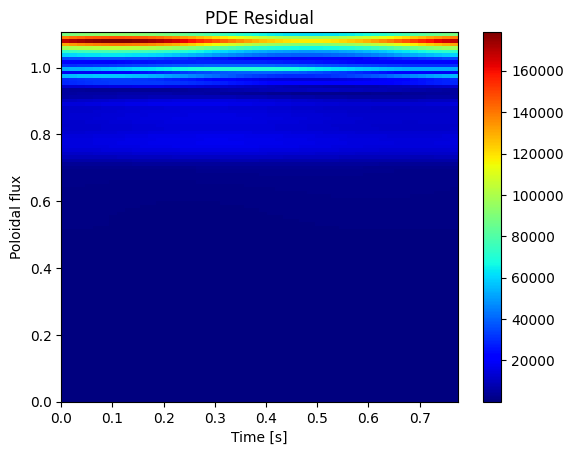

In [45]:
rho = np.sqrt(psi_n)
dVdrho = dVdx * 2 * rho.reshape(-1, 1)

# Temporal derivative
dndt = np.gradient(n_e, t, axis=1)

# Spatial derivative
dndx = np.gradient(n_e, rho, axis=0)
d2ndx2 = np.gradient(dndx, rho, axis=0)

# Transport term
transport = dVdrho * g2 * D * dndx - g1 * V * n_e
dtransportdx = np.gradient(transport, rho, axis=0)

residual = dVdx*dndt - (dtransportdx + np.gradient((S - n_e * itaupar), rho, axis=0))


plt.imshow(abs(residual), aspect='auto', cmap='jet', origin='lower', extent=[t[0], t[-1], psi_n[0], psi_n[-1]])
plt.xlabel('Time [s]')
plt.ylabel('Poloidal flux')
plt.title('PDE Residual')
plt.colorbar()
plt.show()


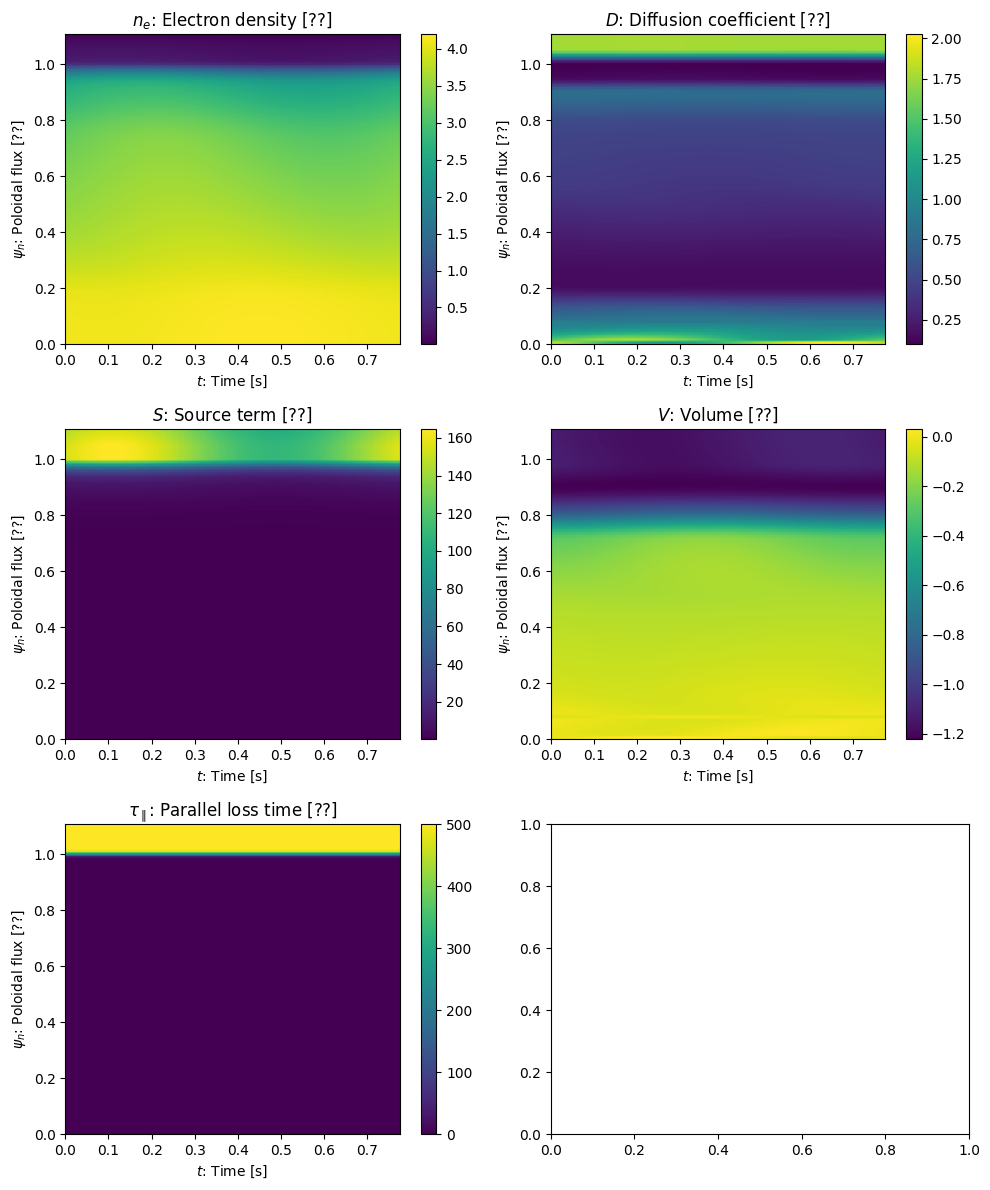

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Plot each subplot with labels and titles
data_array = [(n_e, r'$n_e$: Electron density [??]'),
              (D, r'$D$: Diffusion coefficient [??]'),
              (S, r'$S$: Source term [??]'),
              (V, r'$V$: Volume [??]'),
              (itaupar, r'$\tau_{\parallel}$: Parallel loss time [??]')]

for i, (data_array, title) in enumerate(data_array):
    ax = axes[i // 2, i % 2]
    c = ax.imshow(data_array, aspect='auto', origin='lower', extent=[t[0], t[-1], psi_n[0], psi_n[-1]])
    ax.set_xlabel(r'$t$: Time [s]')
    ax.set_ylabel(r'$\psi_n$: Poloidal flux [??]')
    ax.set_title(title)
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()


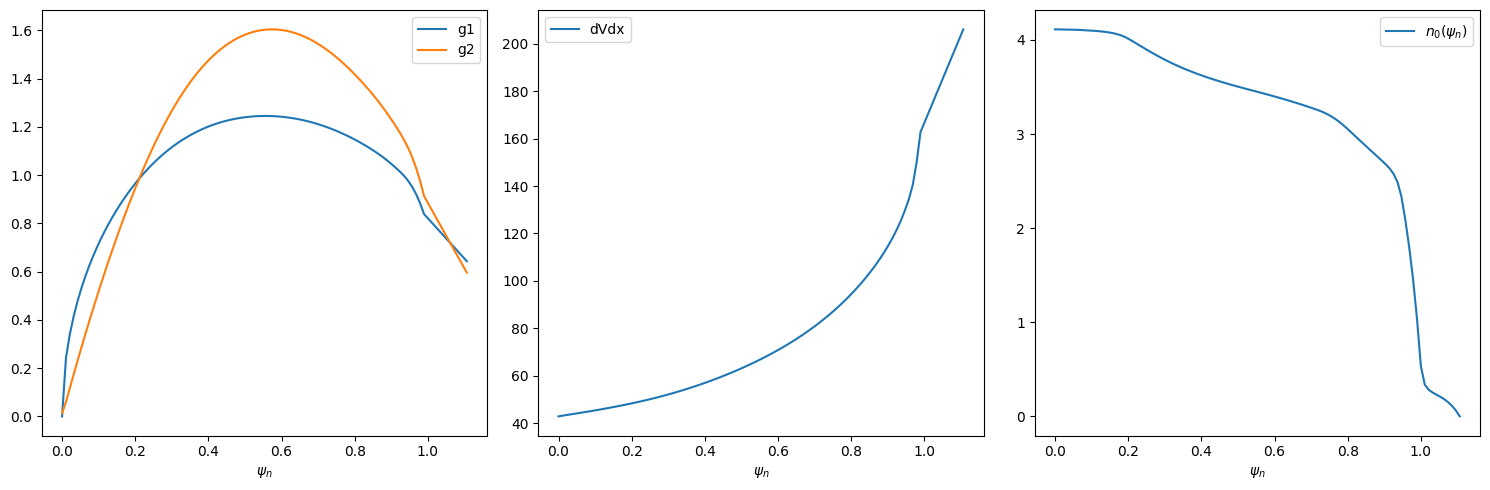

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(psi_n, g1, label='g1')
axes[0].plot(psi_n, g2, label='g2')
axes[0].set_xlabel(r'$\psi_n$')
axes[0].legend()

axes[1].plot(psi_n, dVdx, label='dVdx')
axes[1].set_xlabel(r'$\psi_n$')
axes[1].legend()

axes[2].plot(psi_n, n0, label=r'$n_0(\psi_n)$')
axes[2].set_xlabel(r'$\psi_n$')
axes[2].legend()

plt.tight_layout()
plt.show()

# Inspection of Plasma Data

In [8]:
def print_datadict(data):
    pad = 60
    print("-"*pad)
    print("Key".ljust(20), "Shape or Value", "\tRange")
    print("-"*pad)
    for key in data:
        try:
            val = data[key].shape if data[key].shape != () else data[key]
            print(f"{key}".ljust(20), val, f"\t\t[{data[key].min():.2f}, {data[key].max():.2f}]")
        except:
            val = data[key] if type(data[key]) != np.ndarray else "dict"
            print(f"{key}".ljust(20), val)
    print("-"*pad)

In [9]:
print_datadict(data)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
psin                 (105,) 		[0.00, 1.11]
rhotor               (105,) 		[0.00, 1.05]
t                    (50,) 		[0.00, 0.78]
ne                   (105, 50) 		[0.01, 4.25]
te                   (105, 50) 		[27.71, 2360.24]
nbi_src              (105, 50) 		[0.00, 0.48]
eirene_src           (105,) 		[0.00, 136.83]
g1                   (105,) 		[0.00, 1.25]
g2                   (105,) 		[0.01, 1.60]
dVdpsin              (105,) 		[42.93, 206.01]
rmaj                 (105,) 		[2.80, 2.95]
area                 (105,) 		[0.00, 148.53]
te_data              dict
eq                   dict
prob                 dict
sol                  dict
o                    dict
fsa                  dict
coord                0 		[0.00, 0.00]
eq_full              dict
aaro_origsrc         (12,) 		[16499262690313633792.00, 3953118170992535928832.00

### $\texttt{te\_data}$ - 

In [10]:
te_data = data['te_data'][()]
for key in te_data:
    print("-"*30)
    print(f"{key}".center(30, ' '))
    print("-"*30)
    for key2 in te_data[key]:
        try:
            print(f"{key2:<20} {te_data[key][key2].shape}")
        except:
            print(f"{key2:<20} {te_data[key][key2]}")
print("-"*30)

------------------------------
              te              
------------------------------
amp                  (105,)
pha                  (105,)
ss                   (105,)
freq                 1.29
amp_err              (105,)
pha_err              (105,)
ss_err               (105,)
------------------------------
             gte              
------------------------------
amp                  (105,)
pha                  (105,)
ss                   (105,)
freq                 1.29
amp_err              (105,)
pha_err              (105,)
ss_err               (105,)
------------------------------
             lte              
------------------------------
amp                  (105,)
pha                  (105,)
ss                   (105,)
freq                 1.29
amp_err              (105,)
pha_err              (105,)
ss_err               (105,)
------------------------------


### $\texttt{eq}$ - Equilibrium

In [11]:
eq = data['eq'][()]
print_datadict(eq)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
t                    57.02857 		[57.03, 57.03]
psi                  (65, 65) 		[0.42, 2.71]
faxs                 0.42377034 		[0.42, 0.42]
fbnd                 1.5233516 		[1.52, 1.52]
rbnd                 (500,) 		[1.99, 3.80]
zbnd                 (500,) 		[-1.33, 1.76]
rmag                 2.952532 		[2.95, 2.95]
zmag                 0.38834146 		[0.39, 0.39]
rsil                 2.41572 		[2.42, 2.42]
rsol                 2.8846757 		[2.88, 2.88]
zsil                 -1.579748 		[-1.58, -1.58]
zsol                 -1.5784608 		[-1.58, -1.58]
rxpl                 2.6904309 		[2.69, 2.69]
zxpl                 -1.3255389 		[-1.33, -1.33]
rmjo                 (65,) 		[2.95, 3.80]
jsur                 (65,) 		[-1669086.62, 1.35]
q                    (65,) 		[1.04, 7.54]
volm                 72.44376 		[72.44, 72.44]
vjac     

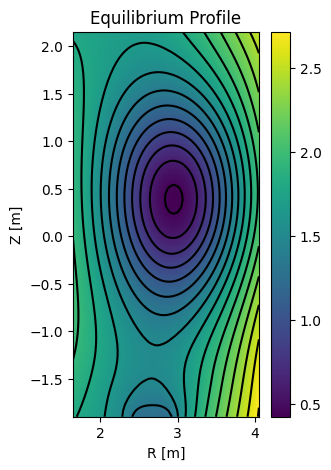

In [ ]:
# Plot
r = eq['r']
z = eq['z']
R, Z = np.meshgrid(r, z)

plt.figure(figsize=(3, 5))
plt.imshow(eq['psi'], extent=[r.min(), r.max(), z.min(), z.max()], origin='lower', aspect='auto')
plt.colorbar()
plt.contour(R, Z, eq['psi'], 20, colors='black')
plt.title('Equilibrium Profile')
plt.xlabel('R [m]')
plt.ylabel('Z [m]')
plt.show()

### $\texttt{prob}$ - Optimization problem?

In [13]:
prob = data['prob'][()]
print_datadict(prob)


------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
x                    (105,) 		[0.00, 1.11]
D                    (105, 50) 		[0.10, 2.02]
V                    (105, 50) 		[-1.22, 0.03]
S                    (105, 50) 		[0.00, 164.54]
dVdx                 (105,) 		[42.93, 206.01]
g1                   (105,) 		[0.00, 1.25]
g2                   (105,) 		[0.01, 1.60]
bc                   (50,) 		[0.00, 0.00]
n0                   (105,) 		[0.00, 4.11]
tout                 (50,) 		[0.00, 0.78]
itaupar              (105, 50) 		[0.00, 500.00]
do_not_fail          True
maxcycles            50.0
nx                   95.0
nt                   50.0
src_wid              0.05
rtol                 0.0001
print                100.0
alpha                10.0
amp_wgt              200000.0
optiter              20000.0
psin_max             1.1
dt_mul               1.0
nloop                10.

### $\texttt{sol}$ - Solution

In [14]:
sol = data['sol'][()]
print_datadict(sol)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
ne                   (105, 50) 		[0.00, 4.20]
t                    (50,) 		[0.00, 0.78]
x                    (105,) 		[0.00, 1.11]
Nsteps               102392
Ncycles              2
t_used               0.009387016296386719
------------------------------------------------------------


### $\texttt{o}$ - Output

In [15]:
o = data['o'][()]
print_datadict(o)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
amp                  (105,) 		[55742942661869368.00, 2010584496510536704.00]
pha                  (105,) 		[5.25, 8.40]
ss                   (105,) 		[218923911161990880.00, 42186665658966581248.00]
freq                 1.29
amp_err              (105,) 		[0.00, 45179244277026272.00]
pha_err              (105,) 		[0.00, 0.10]
ss_err               (105,) 		[0.00, 32709007077067620.00]
rho                  (105,) 		[0.00, 1.05]
------------------------------------------------------------


### $\texttt{fsa}$ - Flux Surface Averaging

In [16]:
fsa = data['fsa'][()]
print_datadict(fsa)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
Bp                   (105,) 		[-0.17, 0.47]
<grad(rhot)>         (105,) 		[0.88, 5.62]
<grad(rhot)**2>      (105,) 		[0.78, 16.65]
<grad(rhop)>         (105,) 		[-0.24, 1.36]
<grad(rhop)**2>      (105,) 		[-0.20, 1.85]
R                    (105,) 		[2.56, 2.95]
R**2                 (105,) 		[6.41, 8.87]
<grad(psin)>         (105,) 		[-0.46, 1.25]
<grad(psin)**2>      (105,) 		[-0.74, 1.60]
Area                 (105,) 		[0.00, 168.84]
dVpsin               (105,) 		[42.93, 217.07]
dVpol                (105,) 		[0.00, 443.29]
dVtor                (105,) 		[0.00, 132.57]
rhopol               (105,) 		[0.00, 1.05]
rhotor               (105,) 		[-0.00, 1.91]
psin                 (105,) 		[-0.00, 1.11]
Vol                  (105,) 		[0.00, 91.11]
------------------------------------------------------------


### $\texttt{eq\_full}$ - Full equilibrium

In [17]:
eq_full = data['eq_full'][()]
print_datadict(eq_full)

------------------------------------------------------------
Key                  Shape or Value 	Range
------------------------------------------------------------
psi                  (279, 65, 65) 		[-1.13, 3.17]
faxs                 (279,) 		[-1.13, 1.71]
fbnd                 (279,) 		[-0.97, 2.05]
rbnd                 (279, 500) 		[1.84, 3.89]
zbnd                 (279, 500) 		[-1.46, 1.88]
rmag                 (279,) 		[2.87, 3.18]
zmag                 (279,) 		[0.11, 0.40]
rxpl                 (279,) 		[0.00, 2.70]
zxpl                 (279,) 		[-1.46, 0.00]
rmjo                 (279, 65) 		[2.87, 3.89]
jsur                 (279, 65) 		[-1979434.00, 152767.77]
q                    (279, 65) 		[0.85, 51.57]
volm                 (279,) 		[40.30, 82.00]
vjac                 (279, 65) 		[21.47, 283.26]
zsol                 (279,) 		[-1.74, 0.00]
rsol                 (279,) 		[0.00, 2.94]
rsil                 (279,) 		[0.00, 2.42]
zsil                 (279,) 		[-1.73, 0.00]
f        

## Visualize data

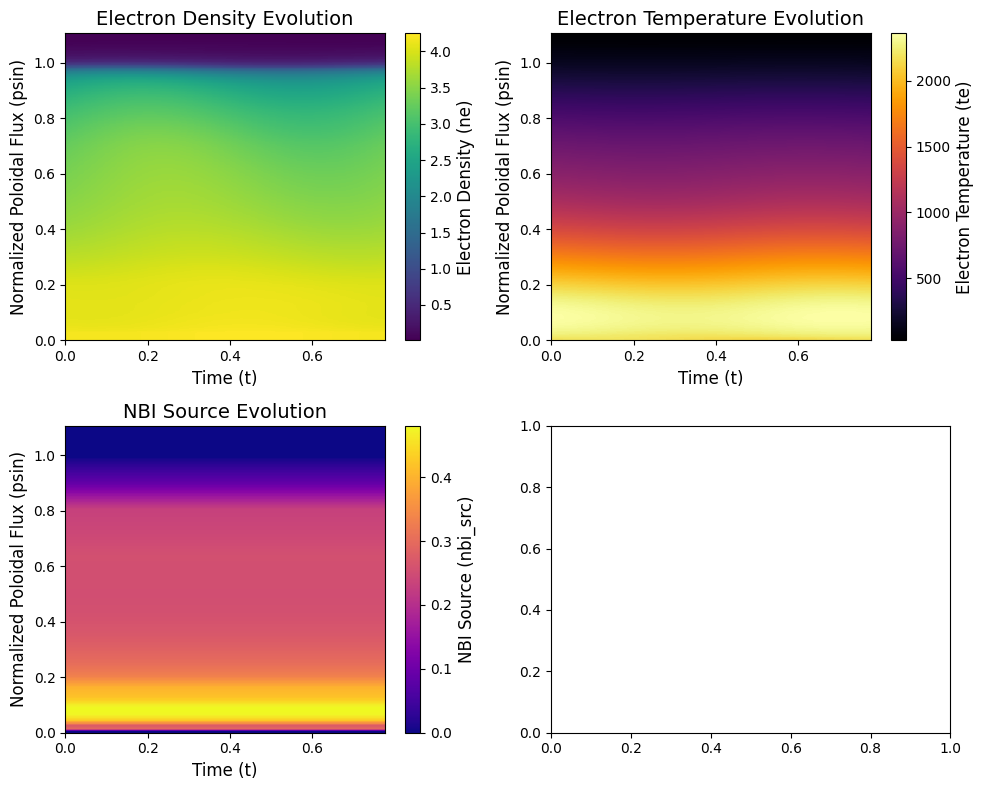

In [ ]:
# Create meshgrid
PSIN, T = np.meshgrid(data['psin'], data['t'], indexing='ij')

# Create the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot for Electron Density (ne)
im1 = axes[0, 0].imshow(data['ne'], aspect='auto', origin='lower', 
                     extent=[data['t'].min(), data['t'].max(), data['psin'].min(), data['psin'].max()], 
                     cmap='viridis')
cbar1 = fig.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Electron Density (ne)', fontsize=12)
axes[0, 0].set_xlabel('Time (t)', fontsize=12)
axes[0, 0].set_ylabel('Normalized Poloidal Flux (psin)', fontsize=12)
axes[0, 0].set_title('Electron Density Evolution', fontsize=14)

# Plot for Electron Temperature (te)
im2 = axes[0, 1].imshow(data['te'], aspect='auto', origin='lower', 
                     extent=[data['t'].min(), data['t'].max(), data['psin'].min(), data['psin'].max()], 
                     cmap='inferno')
cbar2 = fig.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('Electron Temperature (te)', fontsize=12)
axes[0, 1].set_xlabel('Time (t)', fontsize=12)
axes[0, 1].set_ylabel('Normalized Poloidal Flux (psin)', fontsize=12)
axes[0, 1].set_title('Electron Temperature Evolution', fontsize=14)

# Plot nbi_src
im3 = axes[1, 0].imshow(data['nbi_src'], aspect='auto', origin='lower', 
                     extent=[data['t'].min(), data['t'].max(), data['psin'].min(), data['psin'].max()], 
                     cmap='plasma')
cbar3 = fig.colorbar(im3, ax=axes[1, 0])
cbar3.set_label('NBI Source (nbi_src)', fontsize=12)
axes[1, 0].set_xlabel('Time (t)', fontsize=12)
axes[1, 0].set_ylabel('Normalized Poloidal Flux (psin)', fontsize=12)
axes[1, 0].set_title('NBI Source Evolution', fontsize=14)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()
